In [1]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from PIL import Image
import cv2
import os

### Path to zip folder
zip_path = "C:/Users/Sven Jacob/Downloads/Video_006.zip"

img_folder = "Video_006/Video_006/"

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    file_names = zip_file.namelist()
    print(file_names)
    png_files = [f for f in file_names if f.startswith("Video_006/Video_006/Img") and f.lower().endswith(".bmp")]
    png_files = np.sort(png_files)
    #print(png_files)
    frames = []
    for png in png_files:
        with zip_file.open(png) as file:
            image_bytes = file.read()
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
            frames.append(image)

['Video_006/', 'Video_006/Video_006/', 'Video_006/Video_006.avi', 'Video_006/Video_006.xml', 'Video_006/Video_006/Img_00039.bmp', 'Video_006/Video_006/Img_00040.bmp', 'Video_006/Video_006/Img_00041.bmp', 'Video_006/Video_006/Img_00042.bmp', 'Video_006/Video_006/Img_00043.bmp', 'Video_006/Video_006/Img_00044.bmp', 'Video_006/Video_006/Img_00045.bmp', 'Video_006/Video_006/Img_00046.bmp', 'Video_006/Video_006/Img_00385.bmp', 'Video_006/Video_006/Img_00386.bmp', 'Video_006/Video_006/Img_00387.bmp', 'Video_006/Video_006/Img_00388.bmp', 'Video_006/Video_006/Img_00389.bmp', 'Video_006/Video_006/Img_00390.bmp', 'Video_006/Video_006/Img_00391.bmp', 'Video_006/Video_006/Img_00392.bmp', 'Video_006/Video_006/Img_00393.bmp', 'Video_006/Video_006/Img_00394.bmp', 'Video_006/Video_006/Img_00395.bmp', 'Video_006/Video_006/Img_00461.bmp', 'Video_006/Video_006/Img_00462.bmp', 'Video_006/Video_006/Img_00463.bmp', 'Video_006/Video_006/Img_00464.bmp', 'Video_006/Video_006/Img_00465.bmp', 'Video_006/Video_00

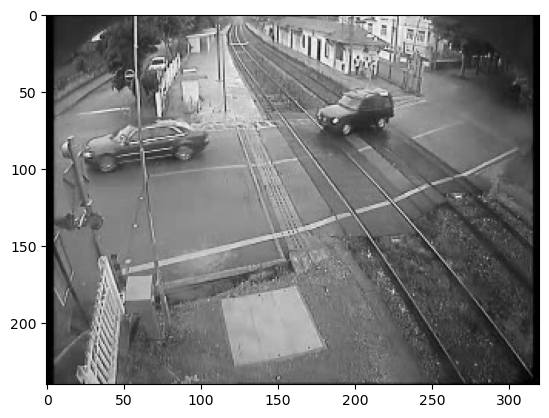

In [2]:
plt.imshow(frames[75],cmap='gray')

In [3]:
M = np.vstack([f.flatten() for f in frames])
M.shape

(86, 76800)

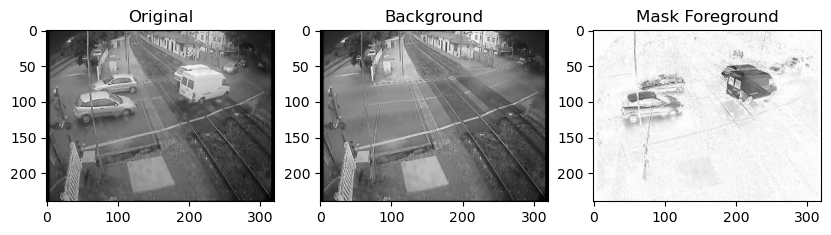

In [4]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=1
S_truncated = np.zeros_like(s)
S_truncated[:L] = s[:L]


frame = 65
M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[1].imshow(background_frames[frame],cmap='gray')
ax[1].set_title('Background')
ax[0].imshow(frames[frame],cmap='gray');
ax[0].set_title('Original')
ax[2].imshow(np.abs(frames[frame]-background_frames[frame]),cmap='binary');
ax[2].set_title('Mask Foreground');

## Yolo 11 no attack

In [146]:
from ultralytics import YOLO
from torchvision import transforms
import torch

# Load a pretrained YOLO11n model
model = YOLO("yolo11n.pt")

frame=65

## need to resize it such that w and h is divisible by 32 and has 3 channels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480,640)) # Resize to model's expected input size
])

img_tensor = transform(frames[frame]).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows() # list of Results objects


0: 480x640 5 cars, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


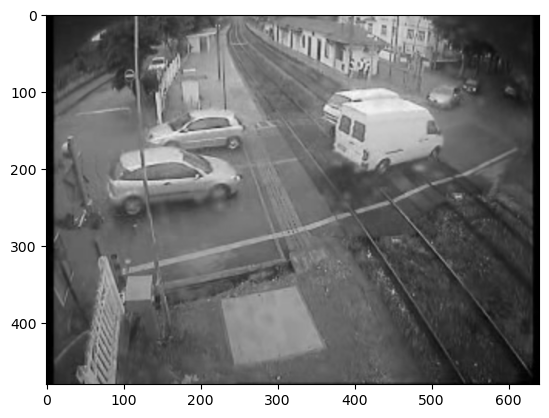

In [9]:
plt.imshow(results[0].orig_img)

In [16]:
SIZE = frames[0].shape

## Attacks on max singular value

In [199]:
s.shape

(86,)

[ 3.0278e+05           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0
           0           0           0           0           0 

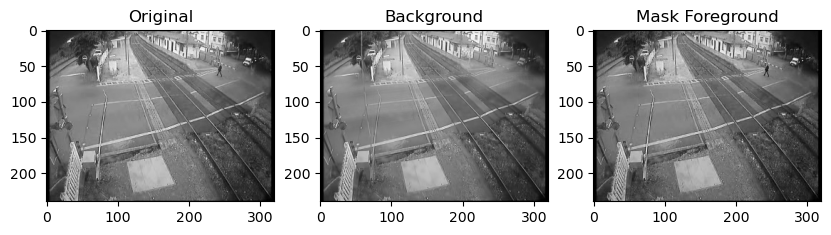

In [194]:
U,s,Vt = np.linalg.svd(M,full_matrices=False)
L=0
S_truncated = np.zeros_like(s)
S_truncated[L:L+1] = s[L:L+1]

S_truncated[0] = S_truncated[0].copy()
print(S_truncated)
U = U.copy() + np.random.uniform(0,0.2,U.shape)
#Vt = Vt.copy() + np.random.normal(0,0.001,Vt.shape)


frame = 1
M_background = U @ np.diag(S_truncated) @ Vt 
background_frames = M_background.reshape((-1, frames[0].shape[0],frames[0].shape[1]))
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[1].imshow(background_frames[frame],cmap='gray')
ax[1].set_title('Background')
ax[0].imshow(frames[frame],cmap='gray');
ax[0].set_title('Original')
ax[2].imshow(np.abs(frames[frame]-background_frames[frame]),cmap='gray');
ax[2].set_title('Mask Foreground');


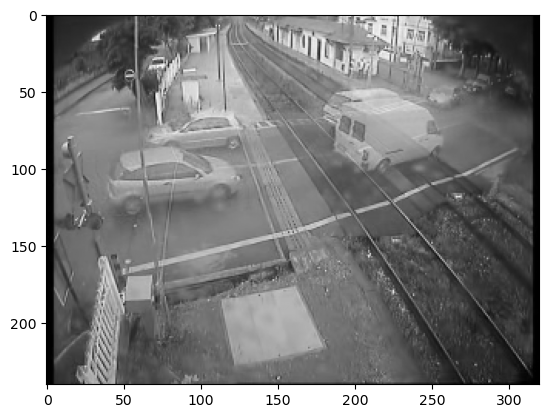

In [171]:
Attack_frame =  frames[frame] +background_frames[frame] 

plt.imshow(Attack_frame,cmap='gray')

In [172]:
Attack_frame =  frames[frame] +background_frames[frame] 


img_tensor = transform(Attack_frame).unsqueeze(0) 

img_tensor = torch.stack((img_tensor.squeeze(0),)*3,dim=1)


# Run inference on the source
results = model(img_tensor,show=True)
cv2.waitKey(0)
cv2.destroyAllWindows() # list of Results ob


WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 440.90412769342345. Dividing input by 255.
0: 480x640 5 cars, 78.9ms
Speed: 0.6ms preprocess, 78.9ms inference, 16.5ms postprocess per image at shape (1, 3, 480, 640)


In [77]:
from ao_exp_grad import AOExpGrad,fmin
from ao_exp_ftrl import fmin as fmin_ftrl

In [65]:
M_normalized = (M/255)-0.5

In [84]:
def loss(X):
    l = 0
    for frame in M_normalized:
        tmp = frame.reshape(SIZE).copy()
        l+=np.linalg.norm(X-tmp)**2
    return 0.5*l


def loss_grad(X):
    l = 0 
    for frame in M_normalized:
        tmp = frame.reshape(SIZE).copy()
        l+=X-tmp
    return l

In [79]:
def callback(res):
    print(res.func)

In [85]:
x_int = np.mean(M,axis=0).reshape(SIZE)

print(loss(x_int))

Result = fmin(loss,loss_grad,x_int,-0.5,0.5,eta=1.0,maxfev=50,l1=1,l2=1,callback=callback,epoch_size=1)
Result

45809001839.82401


c:\Users\Sven Jacob\Documents\Github\MatrixAdvAttacks\ao_exp_grad.py:56: RuntimeWarning: invalid value encountered in log
  x_val = np.where(abc>=15.0,np.log(abc)-np.log(np.log(abc))+np.log(np.log(abc))/np.log(abc), lambertw( np.exp(abc), k=0).real )/b-a


714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642
714657.4513648642


 success: True
       x: [[-5.000e-01 -5.000e-01 ... -5.000e-01 -5.000e-01]
           [-5.000e-01 -5.000e-01 ... -5.000e-01 -5.000e-01]
           ...
           [-5.000e-01 -5.000e-01 ... -5.000e-01 -5.000e-01]
           [-5.000e-01 -5.000e-01 ... -5.000e-01 -5.000e-01]]
     nit: 50
    func: 714657.4513648642
    nfev: 51

(240, 320)

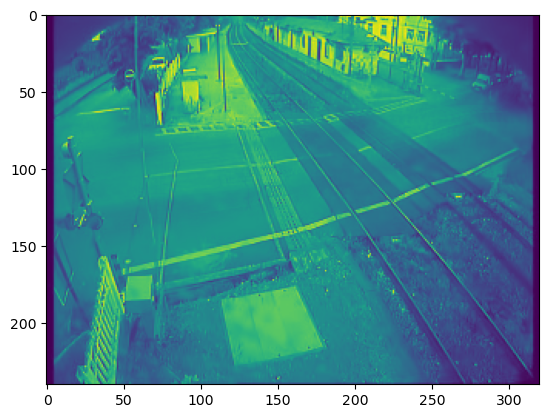

In [75]:
plt.imshow(x_int)
x_int.shape

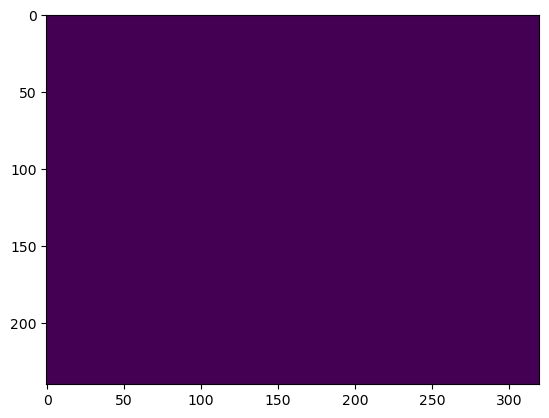

In [69]:
plt.imshow(Result.x)

In [44]:
Result.x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])